<a href="https://colab.research.google.com/github/smnststn/Country-data-analysis/blob/main/Clustering_Country_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

**Data:** *'CountryData.xlsx'*
❗Note: the excel file needs to be uploaded into the Jupyter notebook before running the code

Dataset used in this project contains various socioeconomic indicators for 192 countries.

*  **Missing values:** The dataset has some missing values, which are handled through imputation with the mean value of each column.
*  **Scaling data:** As the dataset includes numerical values of various indicators of a wide range of metric, the data are scaled using StandardScaler before being fed into clustering algorithms.


---


 **Objective:**
The goal is to group countries into clusters based on their similarities across a range of metrics like GDP, CO2 emissions, life expectancy, and internet use, etc. This helps in understanding global development patterns.


---


 **Models Used:**

*  **K-Means model:** This algorithm partitions countries into a predefined number of clusters, aiming to minimize within-cluster variance. The optimal number of clusters was determined using the Elbow Method and the Davies-Bouldin Index.
*  **Agglomerative Hierarchical Clustering (AHC):** This method builds a hierarchy of clusters, merging the closest ones iteratively.


The project offers also several visualizations, such as world maps showing the clusters geographically, boxplots for comparing specific metrics across clusters and scatter plots of the first two PCA components colored by cluster.


In essence, this project uses machine learning to explore and visualize global development, grouping (or clustering) these countries based on their socioeconomic characteristics.

# **Setup**

Import of Python libraries




In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D

#pd.set_option('display.max_columns', 500)

import geopandas as gpd

!pip install --upgrade kneed
from kneed import KneeLocator

Loading data & renaming columns

In [82]:
data = pd.read_excel("CountryData.xlsx", sheet_name = "data")
data.columns = ["Country", "CountryName", "ForeignInvestment", "ElectricityAccess", "RenewableEnergy", "CO2Emission", "Inflation", "MobileSubscriptions", "InternetUse", "Exports", "Imports", "GDP", "MortalityMale", "MortalityFemale", "BirthRate", "DeathRate", "MortalityInfant", "LifeExpectancy", "FertilityRate", "PopulationGrowth", "UrbanPopulation"]
data.head()

# Preview of our dataset

,Country,CountryName,ForeignInvestment,ElectricityAccess,RenewableEnergy,CO2Emission,Inflation,MobileSubscriptions,InternetUse,Exports,...,GDP,MortalityMale,MortalityFemale,BirthRate,DeathRate,MortalityInfant,LifeExpectancy,FertilityRate,PopulationGrowth,UrbanPopulation
0,ABW,Aruba,7.568160,93.356292,5.464716,24.670529,2.077739,129.636369,62.0,61.502448,...,24271.940421,76.722,123.598,11.260,7.919,NaN,75.016,1.776,0.212680,43.059
1,AFG,Afghanistan,0.340097,42.700000,14.839806,0.293837,0.892537,35.467766,4.0,10.023850,...,553.300289,228.971,271.299,39.232,8.095,65.7,61.226,5.816,2.812617,24.689
2,AGO,Angola,-3.913151,33.514950,54.193837,1.243406,14.470541,40.238403,2.8,62.387739,...,3529.053482,233.617,306.825,45.314,10.450,75.4,58.192,6.162,3.570099,40.097
3,ALB,Albania,9.137790,100.000000,37.115330,1.578574,3.552267,91.560929,45.0,27.979471,...,4094.358832,55.601,92.752,11.819,6.776,14.8,76.652,1.653,-0.496462,52.163
4,ARE,United Arab Emirates,3.034620,100.000000,0.108122,19.443690,0.878937,132.105386,68.0,77.713035,...,35049.148317,61.349,87.243,11.656,1.474,7.3,76.344,1.869,7.587098,84.055


In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Country              192 non-null    object 
 1   CountryName          192 non-null    object 
 2   ForeignInvestment    186 non-null    float64
 3   ElectricityAccess    192 non-null    float64
 4   RenewableEnergy      191 non-null    float64
 5   CO2Emission          188 non-null    float64
 6   Inflation            182 non-null    float64
 7   MobileSubscriptions  190 non-null    float64
 8   InternetUse          190 non-null    float64
 9   Exports              185 non-null    float64
 10  Imports              185 non-null    float64
 11  GDP                  191 non-null    float64
 12  MortalityMale        188 non-null    float64
 13  MortalityFemale      188 non-null    float64
 14  BirthRate            191 non-null    float64
 15  DeathRate            191 non-null    flo

# **Preprocessing**

Identifying and inspecting missing data

In [84]:
data.isna().sum()
# Below are missing values present in each column of the dataset:

,0
Country,0
CountryName,0
ForeignInvestment,6
ElectricityAccess,0
RenewableEnergy,1
CO2Emission,4
Inflation,10
MobileSubscriptions,2
InternetUse,2
Exports,7


Out of 192 countries, a maximum of 10 countries have missing data per column, which is quite minimal. This indicates that imputation with the mean is an appropriate strategy to handle missing values, preserving as much of the original data as possible.

In [85]:
na_inflation = data['Inflation'].isna() == True
data[na_inflation]

# The following lines isolate and display the countries with missing inflation data (10 occurances):

,Country,CountryName,ForeignInvestment,ElectricityAccess,RenewableEnergy,CO2Emission,Inflation,MobileSubscriptions,InternetUse,Exports,...,GDP,MortalityMale,MortalityFemale,BirthRate,DeathRate,MortalityInfant,LifeExpectancy,FertilityRate,PopulationGrowth,UrbanPopulation
22,BMU,Bermuda,3.876992,100.000000,2.391769,9.347122,NaN,137.907311,84.21,47.083114,...,88207.327560,NaN,NaN,11.800,7.300,NaN,79.288537,1.7600,-0.780060,100.000
42,CUB,Cuba,NaN,99.963898,13.157632,3.386127,NaN,8.850353,15.90,22.570265,...,5676.141403,74.922,114.850,11.042,7.258,4.7,78.959000,1.6390,0.127576,76.597
52,ERI,Eritrea,4.298455,39.740181,81.246599,0.116921,NaN,4.219580,0.61,4.789012,...,482.149090,253.632,325.122,35.889,8.288,39.1,62.181000,4.6050,1.850516,20.572
70,GUM,Guam,NaN,100.000000,0.000000,NaN,NaN,NaN,54.04,17.282942,...,30700.434008,52.481,89.614,17.669,4.785,NaN,78.134000,2.4720,0.133679,94.099
92,KIR,Kiribati,-4.307572,63.167737,3.464605,0.607285,NaN,10.321280,9.07,13.315807,...,1493.160510,166.838,247.719,29.463,7.134,48.2,65.354000,3.8430,2.051051,43.773
137,PLW,Palau,1.464664,98.584595,0.000000,12.360674,NaN,70.893991,NaN,51.446668,...,8956.282364,NaN,NaN,11.900,8.100,16.5,NaN,NaN,0.627269,83.358
140,PRI,Puerto Rico,NaN,100.000000,0.573634,NaN,NaN,78.940822,45.30,62.671687,...,26435.740187,60.557,156.806,11.300,7.833,NaN,78.408171,1.6235,-0.506170,93.825
170,TKM,Turkmenistan,16.084110,100.000000,0.072193,11.261485,NaN,62.856143,3.00,76.315471,...,4439.203000,140.792,260.710,25.405,7.214,51.8,66.657000,2.8330,1.570290,48.402
181,UZB,Uzbekistan,4.160523,99.986694,2.643497,3.647049,NaN,73.242623,15.90,31.659887,...,1377.082140,114.269,198.049,22.700,4.900,31.7,70.005000,2.3420,2.822850,36.191
184,VIR,Virgin Islands (U.S.),NaN,100.000000,0.000000,NaN,NaN,NaN,31.22,298.340631,...,40043.190166,52.152,84.510,14.800,6.600,NaN,77.965854,2.3000,-0.043365,94.594


Simple imputation of missing data with mean value of the column:

In [86]:
data = data.fillna(X.mean())
data[na_inflation]

# Herebelow we can see missing data for Inflation being replaced by mean value of 4.530093:

,Country,CountryName,ForeignInvestment,ElectricityAccess,RenewableEnergy,CO2Emission,Inflation,MobileSubscriptions,InternetUse,Exports,...,GDP,MortalityMale,MortalityFemale,BirthRate,DeathRate,MortalityInfant,LifeExpectancy,FertilityRate,PopulationGrowth,UrbanPopulation
22,BMU,Bermuda,3.876992,100.000000,2.391769,9.347122,4.530093,137.907311,84.210000,47.083114,...,88207.327560,144.701755,211.737206,11.800,7.300,27.860479,79.288537,1.760000,-0.780060,100.000
42,CUB,Cuba,5.881855,99.963898,13.157632,3.386127,4.530093,8.850353,15.900000,22.570265,...,5676.141403,74.922000,114.850000,11.042,7.258,4.700000,78.959000,1.639000,0.127576,76.597
52,ERI,Eritrea,4.298455,39.740181,81.246599,0.116921,4.530093,4.219580,0.610000,4.789012,...,482.149090,253.632000,325.122000,35.889,8.288,39.100000,62.181000,4.605000,1.850516,20.572
70,GUM,Guam,5.881855,100.000000,0.000000,4.878105,4.530093,89.254314,54.040000,17.282942,...,30700.434008,52.481000,89.614000,17.669,4.785,27.860479,78.134000,2.472000,0.133679,94.099
92,KIR,Kiribati,-4.307572,63.167737,3.464605,0.607285,4.530093,10.321280,9.070000,13.315807,...,1493.160510,166.838000,247.719000,29.463,7.134,48.200000,65.354000,3.843000,2.051051,43.773
137,PLW,Palau,1.464664,98.584595,0.000000,12.360674,4.530093,70.893991,33.096221,51.446668,...,8956.282364,144.701755,211.737206,11.900,8.100,16.500000,70.236538,2.933369,0.627269,83.358
140,PRI,Puerto Rico,5.881855,100.000000,0.573634,4.878105,4.530093,78.940822,45.300000,62.671687,...,26435.740187,60.557000,156.806000,11.300,7.833,27.860479,78.408171,1.623500,-0.506170,93.825
170,TKM,Turkmenistan,16.084110,100.000000,0.072193,11.261485,4.530093,62.856143,3.000000,76.315471,...,4439.203000,140.792000,260.710000,25.405,7.214,51.800000,66.657000,2.833000,1.570290,48.402
181,UZB,Uzbekistan,4.160523,99.986694,2.643497,3.647049,4.530093,73.242623,15.900000,31.659887,...,1377.082140,114.269000,198.049000,22.700,4.900,31.700000,70.005000,2.342000,2.822850,36.191
184,VIR,Virgin Islands (U.S.),5.881855,100.000000,0.000000,4.878105,4.530093,89.254314,31.220000,298.340631,...,40043.190166,52.152000,84.510000,14.800,6.600,27.860479,77.965854,2.300000,-0.043365,94.594


In [87]:
X = data.iloc[:,2:]

## **Standardization of data**



Our dataset contains information about countries, including a variety of metrics like CO2 emissions, life expectancy, and GDP. These metrics are measured in different units and have vastly different ranges. Scaling adjusts these metrics to a comparable scale. This prevents metrics with larger values, such as GDP, from having an undue influence on the analysis, ensuring all metrics contribute equally.

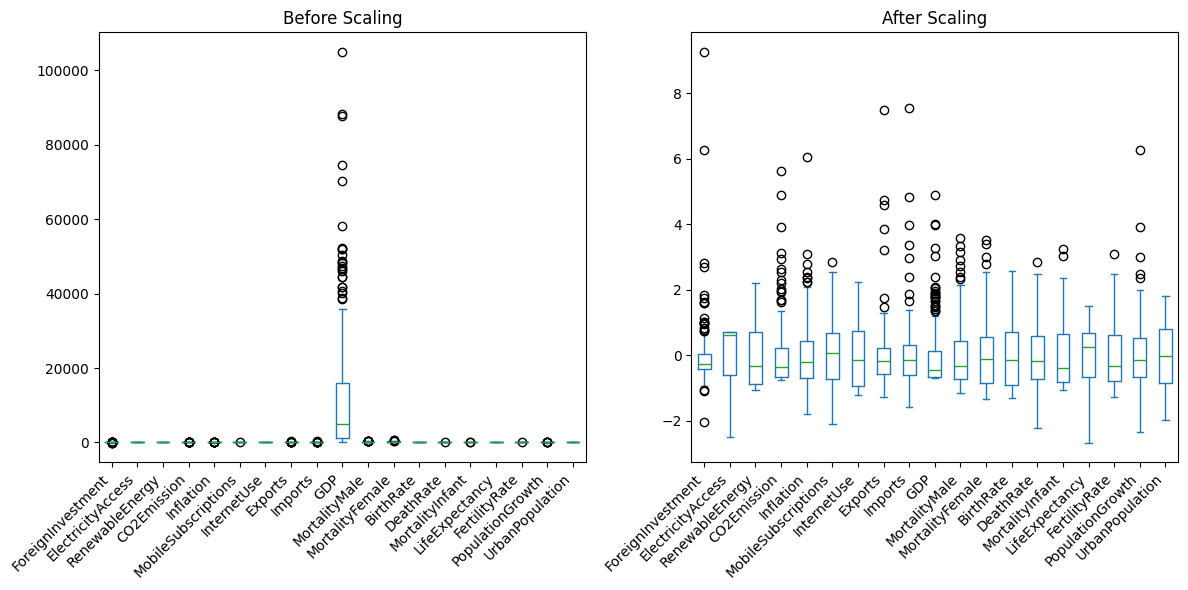

In [88]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Preparation of box plot "Before scaling"
X.plot(kind='box', ax=ax1)
ax1.set_title("Before Scaling")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Applying StandardScaler to scale the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Preparation of box plot "After scaling"
X_scaled_df.plot(kind='box', ax=ax2)
ax2.set_title("After Scaling")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# To visualize the importance of this step, we can compare both box plots "before" and "after scaling" side-by-side

# **Building predictive models**


For each model, there will be a new column added to our dataset. Such columns will store the cluster assignments predicted by that specific model. Each cluster will be represented by a unique number (herein refered to as *label*).

## K-Means

 In order to find the optimal number of clusters for the K-Means algorithm, we will be using a technique called the Elbow Method.

In [89]:
max_clusters = 7
ks = range(1, max_clusters)
inertias = []
db_indices = []

# The following loop records how well the data fits into those clusters based on inertia

for k in ks:
    model = KMeans(n_clusters=k, n_init='auto')
    cluster_labels = model.fit_predict(X_scaled)
    inertias.append(model.inertia_)

    if k > 1:
      db_index = davies_bouldin_score(X_scaled, cluster_labels)
      db_indices.append(db_index)

The loop above calculates inertia for different cluster numbers (k). To determine the best k, we need to visualize these results. This is done by plotting inertia against k, creating a graph known as the 'elbow curve.' The ideal k value is typically located at the curve's 'elbow,' where the rate at which inertia decreases becomes less pronounced.

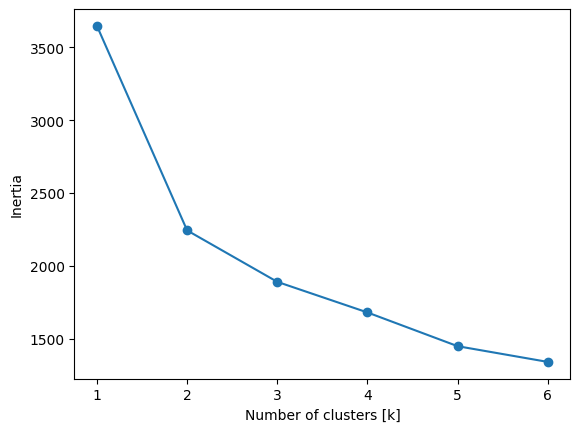

In [90]:
fig, ax = plt.subplots()

ax.plot(ks, inertias, '-o')
ax.set_xlabel('Number of clusters [k]')
ax.set_ylabel('Inertia')
ax.set_xticks(ks)
plt.show()

# The resulting plot is called an "elbow curve":

In [91]:
!pip install --upgrade kneed
from kneed import KneeLocator

Best k value: 2


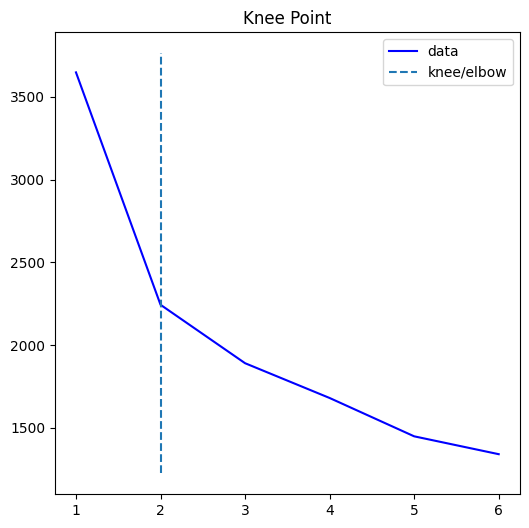

In [92]:
kneedle = KneeLocator(ks, inertias, curve="convex", direction="decreasing")
best_k = kneedle.elbow

print(f"Best k value: {best_k}")
kneedle.plot_knee()

# The curve with the detected elbow point as suggested by KneeLocator:

Another important metric is The Davies-Bouldin index. It is used to evaluate clustering algorithms, where lower scores indicate better clustering.

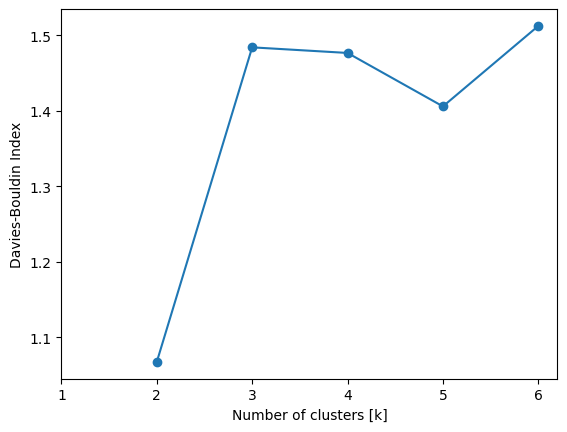

In [93]:
# Now, plot the Davies-Bouldin indices against the number of clusters
fig, ax = plt.subplots()

ax.plot(range(2, max_clusters), db_indices, '-o')
ax.set_xlabel('Number of clusters [k]')
ax.set_ylabel('Davies-Bouldin Index')
ax.set_xticks(ks)
plt.show()

# Following visualization confirms that best number of clusters is 2.

 The Elbow method and Davies-Bouldin index are helpful heuristics but they aren't infallible measures of real-world fit. They focus solely on mathematical properties of the data but do not take into account real-world interpretations.

For n_clusters = 3, the average silhouette_score is : 0.2594935297279701


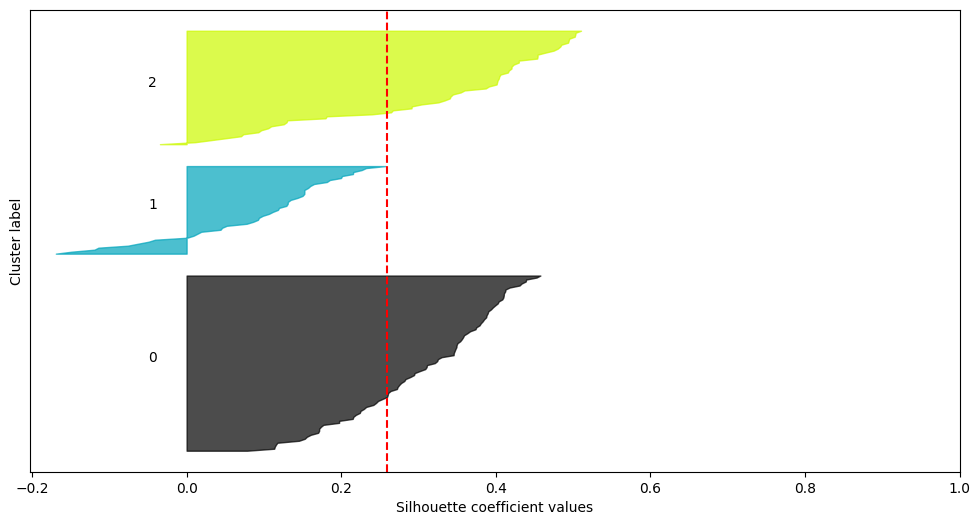

In [94]:
# Should we want to consider different 'best_k', we may simply change following variable:
best_k = 3

kmeans = KMeans(n_clusters=best_k, n_init='auto', random_state=0)
cluster_labels = kmeans.fit_predict(X_scaled)
data["label_KMeans"] = kmeans.fit_predict(X_scaled)

# Calculate silhouette coefficient for each sample
silhouette_avg = silhouette_score(X_scaled, cluster_labels)
print(f"For n_clusters = {best_k}, the average silhouette_score is : {silhouette_avg}")

sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

fig, ax = plt.subplots(figsize=(12, 6))
y_lower = 10

for i in range(best_k):
  ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
  ith_cluster_silhouette_values.sort()
  size_cluster_i = ith_cluster_silhouette_values.shape[0]
  y_upper = y_lower + size_cluster_i
  color = cm.nipy_spectral(float(i) / best_k)
  ax.fill_betweenx(
      np.arange(y_lower, y_upper),
      0,
      ith_cluster_silhouette_values,
      facecolor=color,
      edgecolor=color,
      alpha=0.7,
  )
  ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
  y_lower = y_upper + 10

ax.set_xlabel("Silhouette coefficient values")
ax.set_ylabel("Cluster label")
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_yticks([])
ax.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()

In [95]:
data["label_KMeans"].value_counts().sort_index()

,count
label_KMeans,
0,89
1,45
2,58


## **AHC model**

Agglomerative Hierarchical Clustering (AHC) is a bottom-up clustering algorithm that groups data points by iteratively merging the closest clusters until a desired number of clusters is reached or all points belong to a single cluster.

In [96]:
ahc = AgglomerativeClustering(n_clusters=best_k, linkage='ward') # You can change the linkage if needed
data["label_AHC"] = ahc.fit_predict(X_scaled)

In [97]:
mapping = {}
for label_ahc in data["label_AHC"].unique():
    # Find the most frequent KMeans label for the current AHC label
    kmeans_labels_for_ahc = data[data["label_AHC"] == label_ahc]["label_KMeans"]
    most_frequent_kmeans_label = kmeans_labels_for_ahc.value_counts().index[0]
    mapping[label_ahc] = most_frequent_kmeans_label

# Map AHC labels to KMeans labels
data["AHC_mapped"] = data["label_AHC"].map(mapping)

# Compare mapped AHC labels to KMeans labels
comparison = data["AHC_mapped"] == data["label_KMeans"]
same_clusters = comparison.sum()
total_samples = len(data)
percentage_same = (same_clusters / total_samples) * 100

print(f"{same_clusters} out of {total_samples} samples ({percentage_same:.2f}%) have the same clusters.")


146 out of 192 samples (76.04%) have the same clusters.


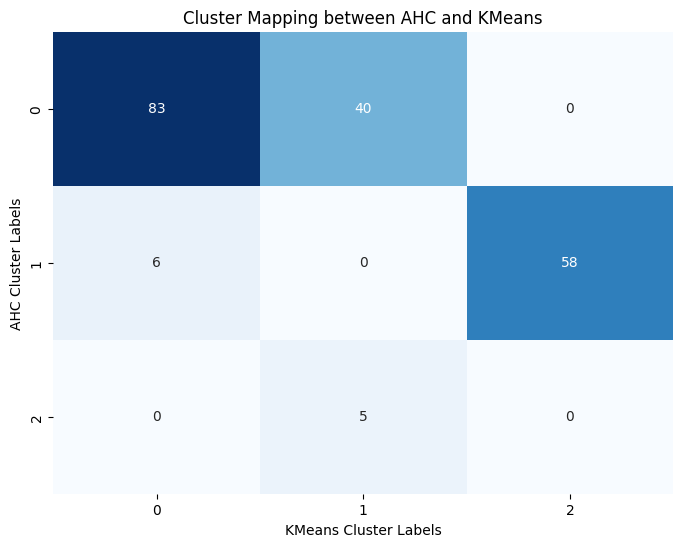

In [98]:
# Create the crosstab
crosstab = pd.crosstab(data["label_AHC"], data["label_KMeans"])

# Visualize the crosstab as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(crosstab, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("KMeans Cluster Labels")
plt.ylabel("AHC Cluster Labels")
plt.title("Cluster Mapping between AHC and KMeans")
plt.show()

In [99]:
data[data['AHC_mapped'] != data['label_KMeans']]
# Below shows sample(s) where cluster label differs:

,Country,CountryName,ForeignInvestment,ElectricityAccess,RenewableEnergy,CO2Emission,Inflation,MobileSubscriptions,InternetUse,Exports,...,BirthRate,DeathRate,MortalityInfant,LifeExpectancy,FertilityRate,PopulationGrowth,UrbanPopulation,label_KMeans,label_AHC,AHC_mapped
0,ABW,Aruba,7.568160,93.356292,5.464716,24.670529,2.077739,129.636369,62.000000,61.502448,...,11.260000,7.919000,27.860479,75.016000,1.776000,0.212680,43.059000,1,0,0
4,ARE,United Arab Emirates,3.034620,100.000000,0.108122,19.443690,0.878937,132.105386,68.000000,77.713035,...,11.656000,1.474000,7.300000,76.344000,1.869000,7.587098,84.055000,1,0,0
8,AUS,Australia,3.080886,100.000000,8.109027,17.740845,2.845226,101.717608,76.000000,19.433714,...,13.700000,6.500000,4.000000,81.695122,1.928000,1.555490,88.733000,1,0,0
9,AUT,Austria,-5.615209,100.000000,30.659217,8.071132,1.813535,145.553796,75.170000,51.262160,...,9.400000,9.200000,3.500000,80.580488,1.440000,0.240394,65.852000,1,0,0
12,BEL,Belgium,23.056704,100.000000,5.837391,10.171465,2.189219,111.110074,75.000000,76.448457,...,11.900000,9.700000,3.700000,80.182927,1.860000,0.913639,97.641000,1,0,0
15,BGD,Bangladesh,1.068935,55.260000,41.050842,0.393937,8.126676,44.642976,3.700000,16.024113,...,21.224000,5.614000,39.100000,70.198000,2.328000,1.119888,30.462000,0,1,2
17,BHR,Bahrain,0.605800,100.000000,0.000000,23.585481,1.961885,126.283181,55.000000,69.537318,...,16.544000,2.326000,7.300000,76.056000,2.164000,4.603905,88.535000,1,0,0
22,BMU,Bermuda,3.876992,100.000000,2.391769,9.347122,4.530093,137.907311,84.210000,47.083114,...,11.800000,7.300000,27.860479,79.288537,1.760000,-0.780060,100.000000,1,0,0
26,BRN,Brunei Darussalam,3.507037,100.000000,0.000000,21.105946,0.356869,111.949200,53.000000,67.410380,...,16.553000,3.196000,8.800000,76.719000,1.838000,1.266145,75.510000,1,0,0
30,CAN,Canada,1.841559,100.000000,22.080989,15.723167,1.776872,75.582109,80.300000,29.071956,...,11.100000,7.100000,4.900000,81.197561,1.626900,1.113960,80.937000,1,0,0


# **Visualizations**

### **Visualization on world map**

In [100]:
# URL to the ZIP file containing the shapefile
!wget https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip -O ne_110m_admin_0_countries.zip
!unzip ne_110m_admin_0_countries.zip -d ne_110m_admin_0_countries

# Load the shapefile
world = gpd.read_file("ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")

# Merge data with the world map
world = world.merge(data, left_on='ISO_A3_EH', right_on='Country', how='left')

--2025-02-21 22:16:54--  https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip
Resolving naciscdn.org (naciscdn.org)... 3.167.212.124, 3.167.212.66, 3.167.212.96, ...
Connecting to naciscdn.org (naciscdn.org)|3.167.212.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 214976 (210K) [application/zip]
Saving to: ‘ne_110m_admin_0_countries.zip’

ne_110m_admin_0_cou 100%[===================>] 209.94K   463KB/s    in 0.5s    

2025-02-21 22:16:55 (463 KB/s) - ‘ne_110m_admin_0_countries.zip’ saved [214976/214976]

Archive:  ne_110m_admin_0_countries.zip
replace ne_110m_admin_0_countries/ne_110m_admin_0_countries.README.html? [y]es, [n]o, [A]ll, [N]one, [r]ename: All
  inflating: ne_110m_admin_0_countries/ne_110m_admin_0_countries.README.html  
 extracting: ne_110m_admin_0_countries/ne_110m_admin_0_countries.VERSION.txt  
 extracting: ne_110m_admin_0_countries/ne_110m_admin_0_countries.cpg  
  inflating: ne_110m_admin_0_countries/ne_110m_adm

In [101]:
def show_map (data, cluster_label):

  cluster_labels = np.unique(data[cluster_label].unique())
  colors = ["red", "green", "blue", "yellow", "cyan"]

  model_name = cluster_label.split("_")[1]

  # Map clusters to colors
  color_map = {cluster: colors[i] for i, cluster in enumerate(cluster_labels)}

  # Assign colors to countries based on cluster labels, default to gray if NaN
  world['color'] = world[cluster_label].map(color_map).fillna('lightgray')

  # Plot the map with clusters
  fig, ax = plt.subplots(1, 1, figsize=(15, 10))
  world.boundary.plot(ax=ax, linewidth=1)
  world.plot(color=world['color'], ax=ax, legend=False)

  # Create custom legend
  legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[cluster], markersize=10, label=f'Label {int(cluster)}') for cluster in cluster_labels]
  legend_handles.append(Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgray', markersize=10, label='Unassigned'))
  ax.legend(handles=legend_handles, title="Label no.", loc='lower left')

  # Add title
  plt.title(f"Segmentation of countries based on {model_name} model")

  # Show plot
  plt.show()


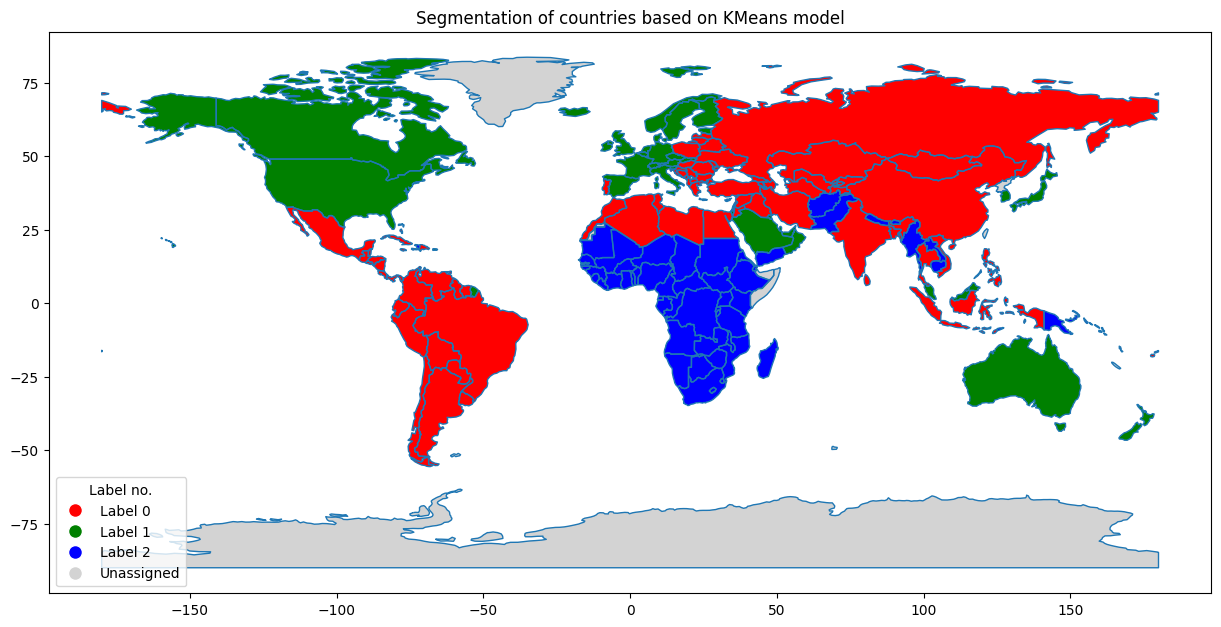

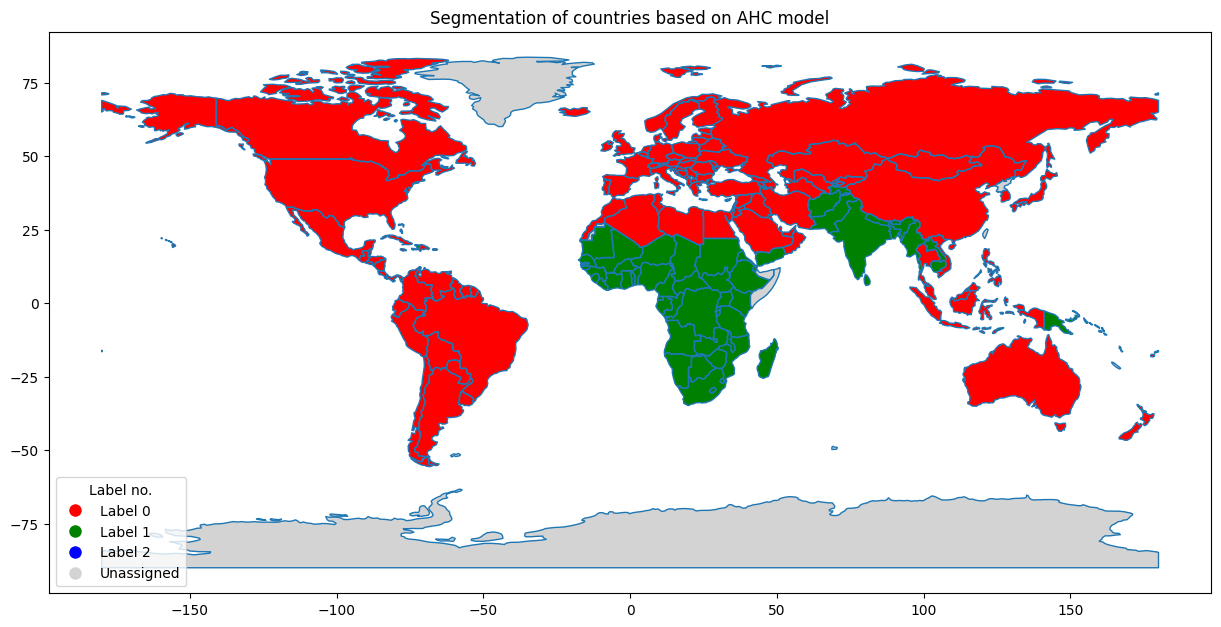

In [102]:
label_columns = [col for col in data.columns if col.startswith("label_")]
for model in label_columns:
  show_map(data, model)


The cluster labeled 2 in the AHC model is barely visible on the world map, so we can identify thereto belonging countries using the simple code below. The table below reveals that this cluster consists of small countries. They appear to form a distinct group, according to AHC model, for a reason which will be explored later in the notebook.

In [103]:
data[data["label_AHC"]==2]
# See the countries corresponding to label 2 in AHC:

,Country,CountryName,ForeignInvestment,ElectricityAccess,RenewableEnergy,CO2Emission,Inflation,MobileSubscriptions,InternetUse,Exports,...,BirthRate,DeathRate,MortalityInfant,LifeExpectancy,FertilityRate,PopulationGrowth,UrbanPopulation,label_KMeans,label_AHC,AHC_mapped
72,HKG,"Hong Kong SAR, China",36.174762,100.0,0.834901,5.791127,2.250000,196.345837,72.00,205.322597,...,12.6,6.0,27.860479,82.978049,1.127,0.734446,100.000,1,2,1
104,LUX,Luxembourg,73.532621,100.0,3.659683,21.635136,2.273405,143.141513,90.62,174.523090,...,11.6,7.4,2.300000,80.631707,1.630,1.825406,88.547,1,2,1
114,MLT,Malta,105.785197,100.0,1.387207,6.174950,1.516834,109.485232,63.00,153.255550,...,9.4,7.3,5.900000,81.397561,1.360,0.491183,94.665,1,2,1
152,SGP,Singapore,23.295596,100.0,0.475165,10.960409,2.800000,145.530809,71.00,199.747457,...,9.3,4.4,2.200000,81.541463,1.150,1.771833,100.000,1,2,1
184,VIR,Virgin Islands (U.S.),5.881855,100.0,0.000000,4.878105,4.530093,89.254314,31.22,298.340631,...,14.8,6.6,27.860479,77.965854,2.300,-0.043365,94.594,1,2,1


### **Visualization on boxplots**


We have the option to display data for models like KMeans and observe the minimum, maximum, and mean values for each cluster. However, the table view is not as informative as a graphical visualization could be.

In [104]:
columns_to_analyze = ["ForeignInvestment", "ElectricityAccess", "RenewableEnergy", "CO2Emission", "Inflation",
                      "MobileSubscriptions", "InternetUse", "Exports", "Imports", "GDP", "MortalityMale",
                      "MortalityFemale", "BirthRate", "DeathRate", "MortalityInfant", "LifeExpectancy",
                      "FertilityRate", "PopulationGrowth", "UrbanPopulation"]

cluster_stats = data.groupby("label_KMeans")[columns_to_analyze].agg(["min", "max", "mean"])

cluster_stats.transpose()

label_KMeans                         0              1             2
ForeignInvestment   min     -15.989220      -5.615209     -4.307572
                    max      23.526337     105.785197     34.992136
                    mean      4.811344       9.073038      5.048618
ElectricityAccess   min      36.898365      93.356292      1.500000
                    max     100.000000     100.000000     89.813774
                    mean     94.388063      99.836567     36.707595
RenewableEnergy     min       0.000000       0.000000      0.963571
                    max      66.585236      75.419692     96.827822
                    mean     20.282156      11.904154     64.445279
CO2Emission         min       0.333031       2.622364      0.024260
                    max      36.092933      40.742018      9.190699
                    mean      3.974421      11.970554      0.762032
Inflation           min      -2.404639      -2.425257     -2.077866
                    max      28.187465       5.393596     16.635224
                    mean      4.901302       2.144201      5.811602
MobileSubscriptions min       8.850353      75.582109      1.184307
                    max     187.414402     208.999216    117.298669
                    mean    101.467182     121.311854     45.641651
InternetUse         min       2.500000      31.220000      0.250000
                    max      68.420000      93.390000     33.096221
                    mean     31.515416      70.621026      6.407866
Exports             min      10.738174      12.378301      0.109124
                    max      93.798781     298.340631     85.758433
                    mean     38.718002      68.490362     31.597148
Imports             min      11.779208      13.576251      0.065880
                    max     108.081823     284.973496    124.083184
                    mean     46.035193      59.826974     45.987601
GDP                 min     738.347523    9071.356987    231.194326
                    max   26917.758979  104965.306078  17136.445676
                    mean   6870.715337   41218.311146   1718.404389
MortalityMale       min      45.639000      28.711000    146.054000
                    max     176.410000     144.701755    508.157000
                    mean    104.576195      57.425790    273.987845
MortalityFemale     min      79.325000      68.677000    182.219000
                    max     365.664000     211.737206    588.836000
                    mean    192.365579     103.180892    325.687362
BirthRate           min       9.000000       8.300000     19.855000
                    max      34.891000      22.018000     50.034000
                    mean     18.374341      12.959836     35.687362
DeathRate           min       3.395000       1.474000      5.477000
                    max      15.200000      11.900000     16.572000
                    mean      7.508269       6.961805      9.870879
MortalityInfant     min       3.100000       2.000000     23.600000
                    max      51.800000      27.860479    106.700000
                    mean     17.475281       8.353599     58.931034
LifeExpectancy      min      66.022000      73.574000     47.560000
                    max      80.387805      82.978049     68.572000
                    mean     72.792995      79.296084     59.284741
FertilityRate       min       1.250000       1.061000      2.382000
                    max       4.562000       3.030000      7.487000
                    mean      2.307487       1.834613      4.746259
PopulationGrowth    min      -2.096943      -0.780060      0.710724
                    max       5.160910      11.220686      4.515622
                    mean      0.934394       1.406534      2.493259
UrbanPopulation     min       9.092000      43.059000     10.641000
                    max      94.414000     100.000000     85.697000
                    mean     56.407615      82.324844     36.303534

Therefore, we can refine our selection to include only the most relevant columns and use boxplots to illustrate the minimum, maximum, and mean values, allowing for an easier comparison of clusters side by side. Let's take labels of KMeans model into following graphics.

<Figure size 800x600 with 0 Axes>

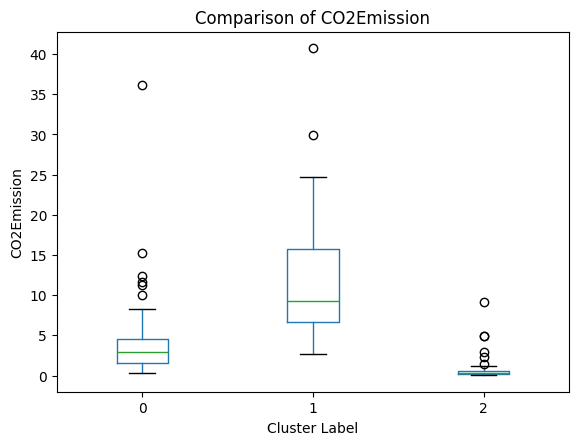

<Figure size 800x600 with 0 Axes>

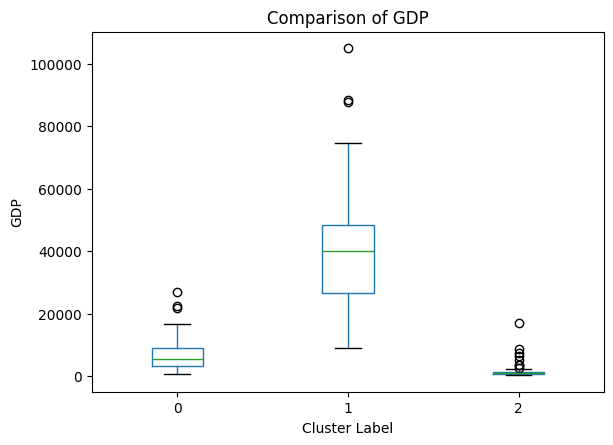

<Figure size 800x600 with 0 Axes>

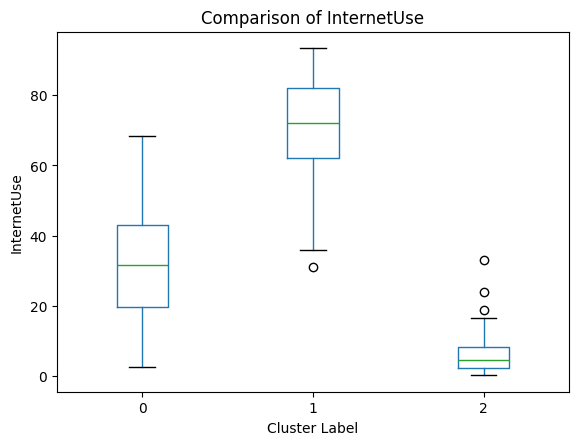

<Figure size 800x600 with 0 Axes>

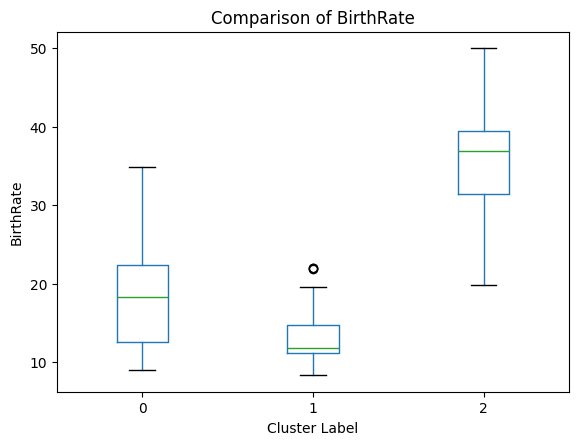

<Figure size 800x600 with 0 Axes>

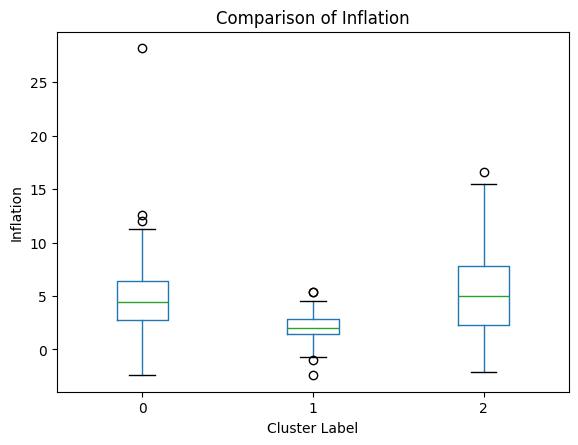

In [105]:
# Select columns for boxplots
columns_to_plot = ["CO2Emission", "GDP", "InternetUse", "BirthRate", "Inflation"]

# Create boxplots for each cluster
for column in columns_to_plot:
    plt.figure(figsize=(8, 6))
    data.boxplot(column=column, by="label_KMeans", grid=False)
    plt.title(f"Comparison of {column}")
    plt.suptitle("")  # Remove the default title
    plt.ylabel(column)
    plt.xlabel("Cluster Label")
    plt.show()

# **Principal Component Analysis (PCA)**

PCA is a dimensionality reduction technique used to transform high-dimensional data into a lower-dimensional representation while preserving as much variance as possible. In other words, this helps to understand how much information is preserved after reducing the data to just two dimensions.

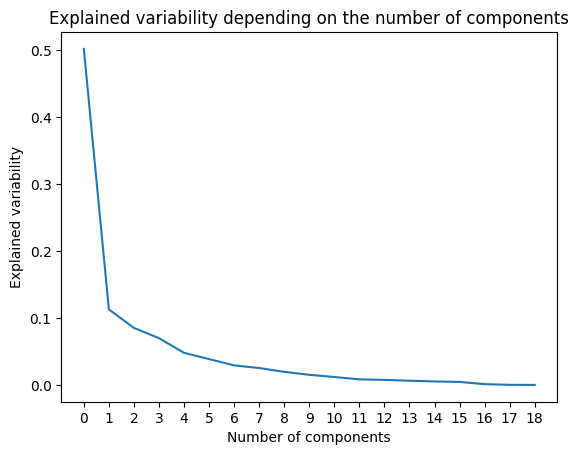

In [106]:
pca = PCA()
pca_features = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_

plt.plot(explained_variance)
plt.xlabel('Number of components')
plt.xticks(range(0,len(explained_variance)))
plt.ylabel('Explained variability')
plt.title('Explained variability depending on the number of components')
plt.show()

# The plot helps in deciding how many principal components to keep.
# Usually, we want to keep the smallest number of components that explain most of the variance in the data.

In [107]:
# Let's therefore focus on the first two components, or alternatively, we can manually set the number of components according to our preference.
n_components = 2

pca = PCA(n_components=n_components)
pca_features = pca.fit_transform(X_scaled)

explained_variance_ratio = pca.explained_variance_ratio_

print(f"Variability explained by the first {n_components} components:")
for i, ratio in enumerate(explained_variance_ratio):
    print(f"   Component {i+1}: {ratio*100:.2f}%")
print(f"Total explained variance: {np.sum(explained_variance_ratio)*100:.2f}%")

Variability explained by the first 2 components:
   Component 1: 50.21%
   Component 2: 11.33%
Total explained variance: 61.54%


In [108]:
pca.explained_variance_

array([9.58947443, 2.16483611])

## **Visualization of PCA1 vs PCA2**

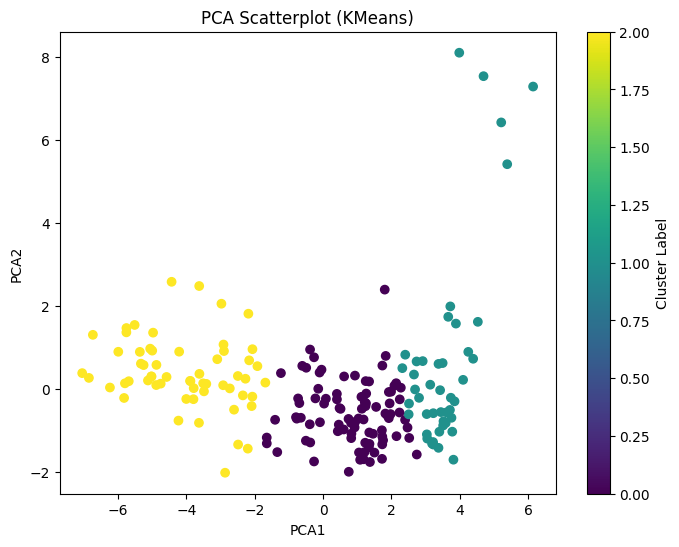

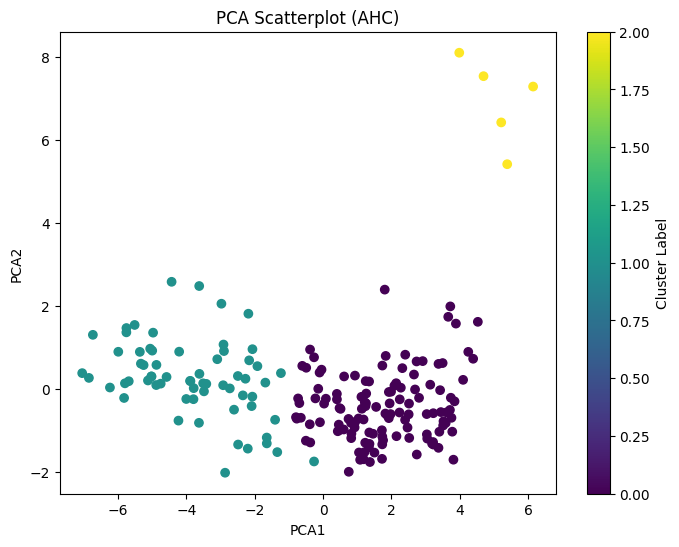

In [109]:
for model in label_columns:
  model_name = model.split("_")[1]

  plt.figure(figsize=(8, 6))
  plt.scatter(pca_features[:, 0], pca_features[:, 1], c=data[model], cmap='viridis')
  plt.xlabel("PCA1")
  plt.ylabel("PCA2")
  plt.title(f"PCA Scatterplot ({model_name})")
  plt.colorbar(label="Cluster Label")
  plt.show()

In [110]:
pca_df = pd.DataFrame(pca_features[:, :2], columns=['PCA1', 'PCA2'])
pca_df['Country'] = data['CountryName']

# Filter for countries with PCA2 > 4 to see the group of 5 aloof countries
aloof_countries = pca_df[pca_df['PCA2'] > 4]
print(aloof_countries[['Country', 'PCA2']])

                   Country      PCA2
72    Hong Kong SAR, China  6.429681
104             Luxembourg  7.293894
114                  Malta  7.543958
152              Singapore  5.423211
184  Virgin Islands (U.S.)  8.109052


Those five aloof countries as depicted on above graph are small, yet highly globalized economies that thrive on trade, finance, and foreign investment. They serve as financial hubs, tax-friendly jurisdictions, and major import-export centers, with high urbanization and advanced infrastructure but low domestic resource bases, making them heavily reliant on external markets.

In [111]:
pca1 = pca_features[:,0]
# Calculate correlations between PCA1 and original scaled variables
correlations_pca1 = pd.Series(np.corrcoef(pca1, X_scaled.T)[0, 1:], index=X.columns)

# Print the correlations
print("Correlations with PCA1:")
print(correlations_pca1.sort_values(ascending=False))

# Positive correlations (higher values) indicate development
# Negative correlations (negative values) denote underdevelopment or socioeconomic challenges

Correlations with PCA1:
LifeExpectancy         0.955276
ElectricityAccess      0.894181
InternetUse            0.855826
MobileSubscriptions    0.770598
UrbanPopulation        0.733806
GDP                    0.679607
CO2Emission            0.596049
Exports                0.403579
Imports                0.195871
ForeignInvestment      0.170080
Inflation             -0.317088
PopulationGrowth      -0.376381
DeathRate             -0.406333
RenewableEnergy       -0.767979
MortalityFemale       -0.828258
FertilityRate         -0.880985
MortalityMale         -0.897311
MortalityInfant       -0.904918
BirthRate             -0.912186
dtype: float64


The common denominator among below indicators, correlated with PCA1, is their correlation with development and economic progress.

The indicators reflect the **Human Development Index (HDI)** or Economic Development Trends, where higher values in some indicators (like life expectancy and internet access) signify development, while high values in others (like birth rate and mortality rates) indicate challenges faced by lower-income countries.

In [112]:
pca2 = pca_features[:,1]
correlations_pca2 = pd.Series(np.corrcoef(pca2, X_scaled.T)[0, 1:], index=X.columns)

# Print the correlations
print("Correlations with PCA2:")
print(correlations_pca2.sort_values(ascending=False))

# Positive correlations indicate trade/globalization
# Negative correlations indicate lower development

Correlations with PCA2:
Imports                0.822765
Exports                0.814960
ForeignInvestment      0.693565
PopulationGrowth       0.274173
GDP                    0.214589
MortalityInfant        0.175585
FertilityRate          0.165959
BirthRate              0.150279
MortalityMale          0.146202
CO2Emission            0.110783
UrbanPopulation        0.087128
MortalityFemale        0.058915
MobileSubscriptions    0.040298
InternetUse            0.016362
RenewableEnergy       -0.002402
DeathRate             -0.017989
LifeExpectancy        -0.107096
Inflation             -0.186761
ElectricityAccess     -0.189658
dtype: float64


The common denominator among these indicators, correlated with PCA2, seems to be trade openness and economic activity related to globalization, as well as healthcare (Infant Mortality, Fertility Rate, Birth Rate, Mortality Male/Female), and last but not least indicators like CO₂ Emissions & Urban Population.

## **Observations**

We observe that dividing the world’s countries into three clusters aligns well with global economic realities. This classification reflects distinct economic patterns, allowing us to see how different nations group based on key financial and developmental indicators. Furthermore, by leveraging our database, we can explore each cluster in greater detail, analyzing specific attributes such as GDP, income levels, and trade dynamics.

*   **Developed Countries:** These nations typically have high GDP per capita, advanced infrastructure, strong institutions, and robust economies. They often have high scores in metrics like life expectancy, internet use, and low infant mortality.

*   **Emerging Countries:** These are nations undergoing rapid industrialization and economic growth. They often have improving infrastructure, rising GDP, and growing middle classes, but may still face challenges like income inequality, environmental issues and moderate scores on metrics like life expectancy and access to electricity.

*   **Developing Countries:** These nations often grapple with poverty, limited access to basic resources, weak institutions, and lower scores on metrics like GDP per capita, life expectancy, internet use and high infant mortality.

A three-cluster model naturally captures these broad categories, which are widely used for understanding global development.


# **Conclusion**

The project successfully grouped countries into clusters based on socioeconomic indicators using K-Means and Agglomerative Hierarchical Clustering (AHC) algorithms.




Although the Elbow Method and Davies-Bouldin index identified 2 as the optimal number of clusters, practical reasoning suggests an alternative (in our case 3 clusters), which better aligns with the real-world classification of countries into developed, emerging, and developing categories.




The K-Means model was used as a primary method, and AHC was used for comparison, with a mapping between AHC and KMeans clusters being created for validation.





Visualizations, including world maps, boxplots, and PCA scatter plots, were used to illustrate the distribution of clusters and the relationships between variables.





PCA was performed to reduce dimensionality and identify key components that explain most of the variance in the dataset. The first two principal components explained a significant portion of the variance and highlighted development and trade/globalization patterns.


---


**Implications:**
*  The clustering analysis provides a clear view of the global development landscape, grouping countries based on similar socioeconomic characteristics.
*  The analysis can be used to identify specific areas where countries need to improve (e.g., increasing access to electricity or decreasing infant mortality).
  
